# Assignment 3
## Training a neural named entity recognition (NER) tagger 

In this assignment you are required to build a full training and testing pipeline for a neural sequentail tagger for named entities, using LSTM.



The dataset that you will be working on is called ReCoNLL 2003, which is a corrected version of the [CoNLL 2003 dataset](https://www.clips.uantwerpen.be/conll2003/ner/): 

- [Train data](https://drive.google.com/file/d/1hG66e_OoezzeVKho1w7ysyAx4yp0ShDz/view?usp=sharing)

- [Dev data](https://drive.google.com/file/d/1EAF-VygYowU1XknZhvzMi2CID65I127L/view?usp=sharing)

- [Test data](https://drive.google.com/file/d/16gug5wWnf06JdcBXQbcICOZGZypgr4Iu/view?usp=sharing)

As you will see, the annotated texts are labeled according to the `IOB` annotation scheme, for 3 entity types: Person, Organization, Location.


NER schemes:  

> `IO`: is the simplest scheme that can be applied to this task. In this scheme, each token from the dataset is assigned one of two tags: an inside tag (I) and an outside tag (O). The I tag is for named entities, whereas the O tag is for normal words. This scheme has a limitation, as it cannot correctly encode consecutive entities of the same type.

> **`IOB`: This scheme is also referred to in the literature as BIO and has been adopted by the Conference on Computational Natural Language Learning (CoNLL) [1]. It assigns a tag to each word in the text, determining whether it is the beginning (B) of a known named entity, inside (I) it, or outside (O) of any known named entities.**

> `IOE`: This scheme works nearly identically to IOB, but it indicates the end of the entity (E tag) instead of its beginning.

> `IOBES`: An alternative to the IOB scheme is IOBES, which increases the amount of information related to the boundaries of named entities. In addition to tagging words at the beginning (B), inside (I), end (E), and outside (O) of a named entity. It also labels single-token entities with the tag S.

> `BI`: This scheme tags entities in a similar method to IOB. Additionally, it labels the beginning of non-entity words with the tag B-O and the rest as I-O.

> `IE`: This scheme works exactly like IOE with the distinction that it labels the end of non-entity words with the tag E-O and the rest as I-O.

> `BIES`: This scheme encodes the entities similar to IOBES. In addition, it also encodes the non-entity words using the same method. It uses B-O to tag the beginning of non-entity words, I-O to tag the inside of non-entity words, and S-O for single non-entity tokens that exist between two entities.


As always, make sure all results are uploaded to CSVs (as well as printed to console) for your assignment to be fully graded.
<br>
<br>  

---

<br>

All additional packages:

In [1]:
# !pip install --q

All imports:
(You may add/change)

In [2]:
# general
import os
import copy
import random
import warnings
from typing import List,Tuple
from collections import defaultdict

# ML
import numpy as np
import scipy as sp
import pandas as pd

# visual
import matplotlib
import seaborn as sns
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
from IPython.display import display

# DL
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.nn.utils.rnn import pad_sequence

# metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score , roc_auc_score, classification_report
from sklearn.metrics import classification_report, confusion_matrix

import requests

set warnings filter to ignore:

In [3]:
warnings.filterwarnings("ignore")

Set random SEEDs:

In [4]:
SEED = 42

# Set the random seed for Python
random.seed(SEED)

# Set the random seed for numpy
np.random.seed(SEED)

# Set the random seed for torch to SEED
torch.manual_seed(SEED)

Set GPU:

In [5]:
# make sure you're using a GPU

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
assert DEVICE == 'cuda'

## Task 1:
Write a function for reading the data from a single file (of the ones that are provided above).   
- The function recieves a filepath 
- The funtion encodes every sentence individually using a pair of lists, one list contains the words and one list contains the tags. 
- Each list pair will be added to a general list (data), which will be returned back from the function.

Example output:
```
[
  (['At','Trent','Bridge',':'],['O','B-LOC','I-LOC ','O']),
  ([...],[...]),
  ...
]
```

In [6]:
def read_data(filepath: str) -> List[Tuple[List[str], List[str]]]:
    data = []

    # Send a GET request to the URL
    response = requests.get(filepath)

    # Get the content of the response
    content = response.text
    lines_data = content.split("\n")
    sentence_words = []
    sentence_tags = []
    for row in lines_data:
        if len(row) == 0:
            if sentence_words and sentence_tags:
                data.append((sentence_words, sentence_tags))
                sentence_words = []
                sentence_tags = []
        else:
            row = row.split(" ")
            sentence_words.append(row[0])
            sentence_tags.append(row[1])
    if len(sentence_words) > 0:
        data.append((sentence_words, sentence_tags))

    return data


# GitHub
train_link = 'https://raw.githubusercontent.com/saharmilis/runi-nlp/94868f8d9de8da9f08498ab5d1b9715acf06671f/NER/connl03_train.txt'
dev_link   = 'https://raw.githubusercontent.com/saharmilis/runi-nlp/94868f8d9de8da9f08498ab5d1b9715acf06671f/NER/connl03_dev.txt'
test_link  = 'https://raw.githubusercontent.com/saharmilis/runi-nlp/94868f8d9de8da9f08498ab5d1b9715acf06671f/NER/connl03_test.txt'

# Google-Drive
# train_link = 'https://drive.google.com/file/d/1hG66e_OoezzeVKho1w7ysyAx4yp0ShDz/view?usp=sharing'
# dev_link   = 'https://drive.google.com/file/d/1EAF-VygYowU1XknZhvzMi2CID65I127L/view?usp=sharing'
# test_link  = 'https://drive.google.com/file/d/16gug5wWnf06JdcBXQbcICOZGZypgr4Iu/view?usp=sharing'

train = read_data(train_link)
dev = read_data(dev_link)
test = read_data(test_link)

<br><br><br><br><br><br>



## Task 2:

The following Vocab class can be served as a dictionary that maps words and tags into Ids.   
The UNK_TOKEN should be used for words that are not part of the training data.

Note: you may change the Vocab class

In [7]:
UNK_TOKEN = None
PAD_TOKEN = 0

class Vocab:
    def __init__(self, train: List[Tuple[List[str], List[str]]]):
        self.word2id = {}
        self.id2word = {}
        self.n_words = 0

        self.tag2id = {}
        self.id2tag = {}
        self.n_tags = 0

        for line in train:
            for w in line[0]:
                self.index_new_word(w)
            for t in line[1]:
                self.index_new_tag(t)

        self.word2id["__unk__"] = np.max([self.n_words, self.n_tags])
        self.id2word[np.max([self.n_words, self.n_tags])] = "__unk__"

    def index_tags(self, tags: List[str]) -> List[int]:
        tag_indexes = [self.tag2id[t] for t in tags]
        return tag_indexes

    def index_words(self, words: List[str]) -> List[int]:
        word_indexes = [self.word2id[w] if w in self.word2id else self.word2id["__unk__"] for w in words]
        return word_indexes

    def index_new_word(self, w: str) -> int:
        if w not in self.word2id:
            self.word2id[w] = self.n_words
            self.id2word[self.n_words] = w
            self.n_words += 1

        return self.word2id[w]

    def index_new_tag(self, t: str) -> int:
        if t not in self.tag2id:
            self.tag2id[t] = self.n_tags
            self.id2tag[self.n_tags] = t
            self.n_tags += 1

        return self.tag2id[t]


# Testing - do not change
vcb = Vocab(train)
assert vcb.tag2id.keys() == {"O":0, "B-PER":1, "I-PER": 2, "B-LOC": 3, "I-LOC": 4, "B-ORG": 5, "I-ORG": 6}.keys()
del vcb

Write a function prepare_data that takes one of the [train, dev, test] and the Vocab instance, for converting each pair of (words,tags) to a pair of indexes.  

Each pair should be added to data_sequences, which will be returned back from the function.

Note: Vocabulary is based only on the train set.

In [8]:
def prepare_data(data, _vocab=None):
    data_sequences = []
    if _vocab is None:
        vocab = Vocab(train)
    else:
        vocab = _vocab

    for line in data:
        data_sequences.append((vocab.index_words(line[0]), vocab.index_tags(line[1])))

    if _vocab:
        return data_sequences
    else:
        return data_sequences, vocab

train_sequences, vocab = prepare_data(train)

UNK_TOKEN = np.max([vocab.n_words, vocab.n_tags])
PAD_TOKEN = np.max([vocab.n_words, vocab.n_tags]) + 1

dev_sequences = prepare_data(dev, vocab)
test_sequences = prepare_data(test, vocab)

In [9]:
def calc_oov(dataset):
    oov_num = 0
    for line in dataset:
        oov_num += (np.array(line[0]) == UNK_TOKEN).sum()

    return oov_num

Print: how many OOV words are in the dev dataset? 

In [10]:
print(calc_oov(dev_sequences))

638


Print: how many OOV words are in the test dataset? 

In [11]:
print(calc_oov(test_sequences))

1368


## Task 3:

Write NERNet, a PyTorch Module for labeling words with NER tags. 

> `input_size`: the size of the vocabulary  
`embedding_size`: the size of the embeddings  
`hidden_size`: the LSTM hidden size  
`output_size`: the number tags we are predicting for  
`n_layers`: the number of layers we want to use in LSTM  
`directions`: could 1 or 2, indicating unidirectional or bidirectional LSTM, respectively  

<br>  

The input for your forward function should be a single sentence tensor.

*Note: the embeddings in this section are learned embedding. That means that you don't need to use pretrained embedding like the one used in class. You will use them in part 5.*

*Note: You may change the NERNet class.* 

In [12]:
class NERNet(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, n_layers, directions):
        super(NERNet, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        is_bidirectional = bool(directions - 1)
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, batch_first=True, bidirectional=is_bidirectional)
        self.out = nn.Linear(directions * hidden_size, output_size)

    def forward(self, input_sentence):
        emb = self.embedding(input_sentence)
        lstm = self.lstm(emb)
        out = self.out(lstm[0])

        return out

Create a Dataloader for the training phase

In [13]:
def prepare_data_loader(sequences, batch_size=64, max_pad_size=None):
    if max_pad_size is not None:
        sequences_padding = [(np.ones(max_pad_size) * PAD_TOKEN, np.ones(max_pad_size) * PAD_TOKEN) for i in range(len(sequences))]
        for i in range(len(sequences)):
            length_sen = np.min([max_pad_size, len(sequences[i][0])])
            sequences_padding[i][0][:length_sen] = sequences[i][0][:length_sen]
            sequences_padding[i][1][:length_sen] = sequences[i][1][:length_sen]
        sequences = sequences_padding

    inputs = [torch.LongTensor(item[0]).to(DEVICE) for item in sequences]
    labels = [torch.LongTensor(item[1]).to(DEVICE) for item in sequences]

    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=PAD_TOKEN)
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=PAD_TOKEN)

    # Create a TensorDataset from the padded input and label tensors
    dataset = TensorDataset(padded_inputs, padded_labels)

    # Create a DataLoader for batching and shuffling the data
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


batch_size = 64
dl_train  = prepare_data_loader(train_sequences , batch_size = batch_size)
dl_dev    = prepare_data_loader(dev_sequences   , batch_size = batch_size)
dl_test   = prepare_data_loader(test_sequences  , batch_size = batch_size)

## Task 4:

Write a training loop, which takes a model (instance of NERNet), number of epochs to train on, and the train&dev datasets.  

The function will return the `loss` and `accuracy` durring training.  
(If you're using a different/additional metrics, return them too)

The loss is always CrossEntropyLoss and the optimizer is always Adam.
Make sure to use `tqdm` while iterating on `n_epochs`.


In [14]:
def train_loop(model, n_epochs, dataloader_train, dataloader_dev):
    # Loss function
    criterion = nn.CrossEntropyLoss().to(DEVICE)

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)

    # Record metrics
    metrics = {'loss': {'train': [], 'dev': []}, 'accuracy': {'train': [], 'dev': []}}

    phases = ['train', 'dev']
    for epoch in tqdm(range(n_epochs), desc='Training'):
        for phase in phases:
            dataset_size = 0
            dataset_correct_prediction_count = 0
            dataset_loss = 0.0

            if phase == 'train':
                model.train()
                dataloader = dataloader_train
            else:
                model.eval()
                dataloader = dataloader_dev

            for inputs, labels in dataloader:
                inputs = inputs.to(DEVICE)
                labels = labels.type(torch.LongTensor)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs).to(DEVICE)
                    results = outputs[(inputs != PAD_TOKEN)]
                    labels = labels[(inputs != PAD_TOKEN)]

                    loss = criterion(results, labels).to(DEVICE)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                _, predicted = torch.max(results, 1)
                dataset_loss += loss.item() * labels.size(0)
                dataset_size += labels.size(0)
                dataset_correct_prediction_count += (predicted == labels).sum().item()

            avg_dataset_loss = dataset_loss / dataset_size
            dataset_accuracy = dataset_correct_prediction_count / dataset_size
            metrics['loss'][phase].append(avg_dataset_loss)
            metrics['accuracy'][phase].append(dataset_accuracy)

## Task 5:
Write an evaluation loop on a trained model, using the dev and test datasets.   
This function will print a `classification_report` and plot a `confusion matrix`.  
Do this for each label seperately (7 labels in total), and add an calculation for all the 6 labels (except O) together.   





Metrics:
- `Recall`: true positive rate (TPR), also known as Recall.
- `Percision`: the opposite to false positive rate (FPR), also known as precision.
- `F1 score`: harmonic average
- *For all these metries use **weighted**:
Calculate metrics for each label, and find their average weighted by support ([link](https://https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support:~:text=imbalance%20into%20account.-,%27weighted%27%3A,-Calculate%20metrics%20for))*

To display:
1. Print a `classification_report` in a `tabulate` format (similar to assignment#2)
2. Display a `confusion matrix` plot: where the predicted labels are the rows, and the true labels are the columns.

Make sure to use the title for the plot, axis names, and the names of the tags on the X-axis.


In [15]:
def evaluate(model, title, dataloader):
    # Set the model to evaluation mode
    model.eval()

    true_labels = []
    predicted_labels = []

    # Iterate over the data loader
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs).to(DEVICE)
            results = outputs[(inputs != PAD_TOKEN)]
            labels = labels[(inputs != PAD_TOKEN)]

            _, predicted = torch.max(results, 1)
            true_labels.extend(labels.tolist())
            predicted_labels.extend(predicted.tolist())

    # Calculate classification report
    report = classification_report(true_labels, predicted_labels, digits=4, output_dict=True)

    # Calculate confusion matrix
    cm = confusion_matrix(predicted_labels, true_labels)

    name_tags = [vocab.id2tag[id] for id in np.sort(np.unique(predicted_labels))]

    plt.figure(figsize=(10, 8))
    plt.matshow(cm, aspect='auto', cmap=plt.get_cmap('Blues'))
    plt.title(f"Confusion Matrix - {title}")
    plt.xticks(range(len(name_tags)), name_tags)
    plt.xlabel("True Labels")

    plt.yticks(range(len(name_tags)), name_tags)
    plt.ylabel("Predicted Labels")

    plt.show()

    report_table = []
    for label, metrics in report.items():
        if label == "accuracy" or label == "weighted avg" or label == "macro avg":
            continue

        row = [vocab.id2tag[int(label)]]
        row.extend([f"{value:.4f}" for value in metrics.values()])
        report_table.append(row)

    headers = ["Label", "Precision", "Recall", "F1-score", "Support"]
    print(tabulate(report_table, headers=headers, tablefmt="github"))

    return report

## Task 6:

Reset all seeds to 42.

In [16]:
SEED = 42

# Set the random seed for Python
random.seed(SEED)

# Set the random seed for numpy
np.random.seed(SEED)

# Set the random seed for torch to SEED
torch.manual_seed(SEED)

Train and evaluate a few models, all with `embedding_size=300`, and with the following hyper parameters (you may use that as captions for the models as well):

- Model 1: (hidden_size: 500, n_layers: 1, directions: 1)
- Model 2: (hidden_size: 500, n_layers: 2, directions: 1)
- Model 3: (hidden_size: 500, n_layers: 3, directions: 1)
- Model 4: (hidden_size: 500, n_layers: 1, directions: 2)
- Model 5: (hidden_size: 500, n_layers: 2, directions: 2)
- Model 6: (hidden_size: 500, n_layers: 3, directions: 2)
- Model 7: (hidden_size: 800, n_layers: 1, directions: 2)
- Model 8: (hidden_size: 800, n_layers: 2, directions: 2)
- Model 9: (hidden_size: 800, n_layers: 3, directions: 2)




In [17]:
columns = ['N_MODEL','HIDDEN_SIZE','N_LAYERS','DIRECTIONS','RECALL','PERCISION','F1','RECALL_WO_O','PERCISION_WO_O','F1_WO_O']
models = {
    'Model1': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 1, 'directions': 1},
    'Model2': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 2, 'directions': 1},
    'Model3': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 3, 'directions': 1},
    'Model4': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 1, 'directions': 2},
    'Model5': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 2, 'directions': 2},
    'Model6': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 3, 'directions': 2},
    'Model7': {'embedding_size':300, 'hidden_size': 800, 'n_layers': 1, 'directions': 2},
    'Model8': {'embedding_size':300, 'hidden_size': 800, 'n_layers': 2, 'directions': 2},
    'Model9': {'embedding_size':300, 'hidden_size': 800, 'n_layers': 3, 'directions': 2},
}

In [18]:
def extract_report_details_from_evaluation(eval_report):
    recall = eval_report['weighted avg']['recall']
    precision = eval_report['weighted avg']['precision']
    f1 = eval_report['weighted avg']['f1-score']

    total_num = 0
    tag_O = str(vocab.tag2id["O"])
    for k in vocab.id2tag.keys():
        tag = str(k)
        if tag == tag_O:
            continue
        total_num += eval_report[tag]['support']

    recall_wo_o = 0
    precision_wo_o = 0
    f1_wo_o = 0
    for k in vocab.id2tag.keys():
        tag = str(k)
        if tag == tag_O:
            continue
        recall_wo_o += (eval_report[tag]['support'] / total_num) * eval_report[tag]['recall']
        precision_wo_o += (eval_report[tag]['support'] / total_num) * eval_report[tag]['precision']
        f1_wo_o += (eval_report[tag]['support'] / total_num) * eval_report[tag]['f1-score']

    return recall, precision, f1, recall_wo_o, precision_wo_o, f1_wo_o

In [19]:
def train_and_evaluate_model(model, model_name, dataloader_train, dataloader_dev, n_epochs=10):
    metrics = train_loop(model, n_epochs, dataloader_train, dataloader_dev)
    eval_report = evaluate(model, f'{model_name} - Dev', dataloader_dev)

    recall, precision, f1, recall_wo_o, precision_wo_o, f1_wo_o = extract_report_details_from_evaluation(eval_report)

    return recall, precision, f1, recall_wo_o, precision_wo_o, f1_wo_o

**Train and Evaluate Metrics and Cunfusion Matrix**





Model1 - Dev confusion matrix & report details


Training: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


<Figure size 1000x800 with 0 Axes>

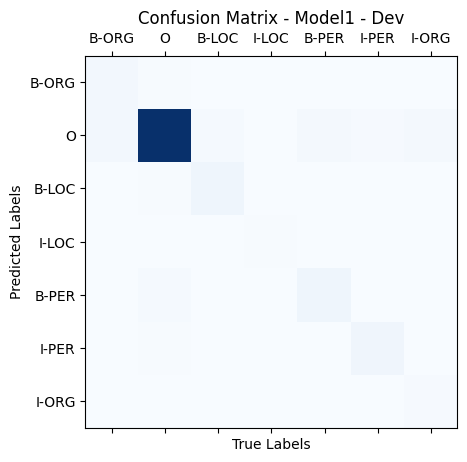

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.6607 |   0.4405 |     0.5286 |       168 |
| O       |      0.9202 |   0.9641 |     0.9416 |      3096 |
| B-LOC   |      0.7866 |   0.7049 |     0.7435 |       183 |
| I-LOC   |      0.65   |   0.5652 |     0.6047 |        23 |
| B-PER   |      0.6537 |   0.67   |     0.6617 |       200 |
| I-PER   |      0.7867 |   0.7516 |     0.7687 |       157 |
| I-ORG   |      0.6875 |   0.2845 |     0.4024 |       116 |




Model1 - Test confusion matrix & report details


<Figure size 1000x800 with 0 Axes>

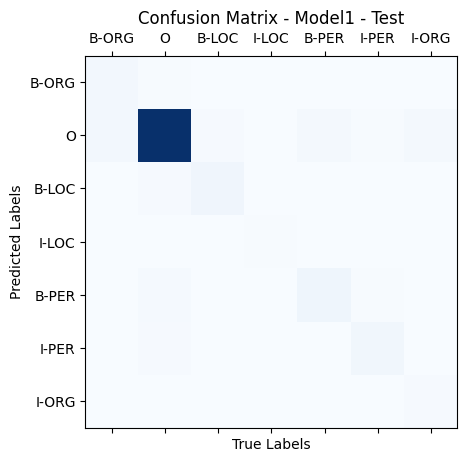

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.6595 |   0.4371 |     0.5258 |       350 |
| O       |      0.9254 |   0.9618 |     0.9432 |      6567 |
| B-LOC   |      0.7462 |   0.7201 |     0.7329 |       343 |
| I-LOC   |      0.68   |   0.6415 |     0.6602 |        53 |
| B-PER   |      0.6297 |   0.6544 |     0.6418 |       434 |
| I-PER   |      0.7544 |   0.7162 |     0.7348 |       296 |
| I-ORG   |      0.6849 |   0.25   |     0.3663 |       200 |




Model2 - Dev confusion matrix & report details


Training: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


<Figure size 1000x800 with 0 Axes>

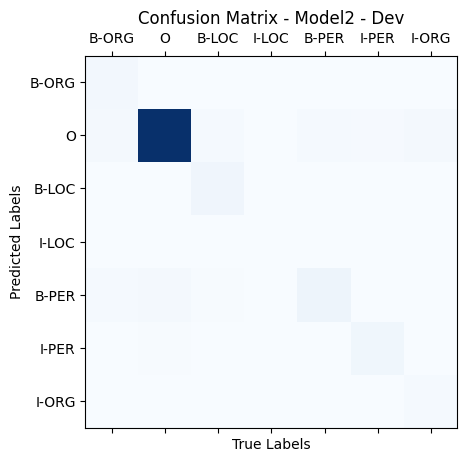

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.7573 |   0.4643 |     0.5756 |       168 |
| O       |      0.9302 |   0.9732 |     0.9512 |      3096 |
| B-LOC   |      0.9297 |   0.6503 |     0.7653 |       183 |
| I-LOC   |      0.8333 |   0.4348 |     0.5714 |        23 |
| B-PER   |      0.567  |   0.74   |     0.6421 |       200 |
| I-PER   |      0.7632 |   0.7389 |     0.7508 |       157 |
| I-ORG   |      0.7917 |   0.3276 |     0.4634 |       116 |




Model2 - Test confusion matrix & report details


<Figure size 1000x800 with 0 Axes>

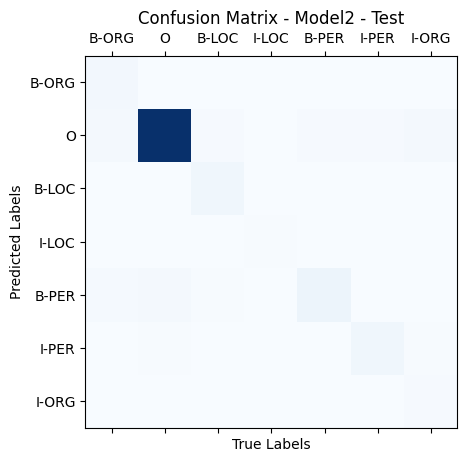

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.7117 |   0.4514 |     0.5524 |       350 |
| O       |      0.9385 |   0.9698 |     0.9539 |      6567 |
| B-LOC   |      0.8949 |   0.6706 |     0.7667 |       343 |
| I-LOC   |      0.931  |   0.5094 |     0.6585 |        53 |
| B-PER   |      0.6007 |   0.7558 |     0.6694 |       434 |
| I-PER   |      0.7209 |   0.7939 |     0.7556 |       296 |
| I-ORG   |      0.7273 |   0.28   |     0.4043 |       200 |




Model3 - Dev confusion matrix & report details


Training: 100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


<Figure size 1000x800 with 0 Axes>

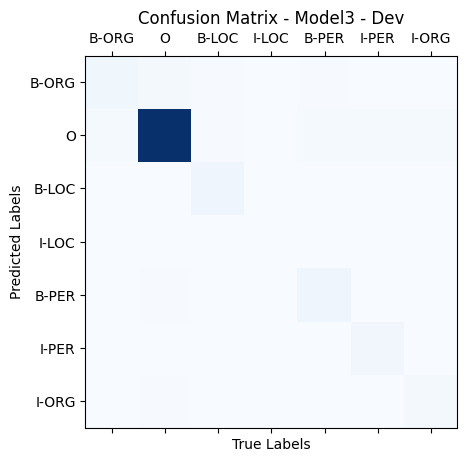

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.5047 |   0.6429 |     0.5654 |       168 |
| O       |      0.9389 |   0.9671 |     0.9527 |      3096 |
| B-LOC   |      0.8477 |   0.6995 |     0.7665 |       183 |
| I-LOC   |      0.9167 |   0.4783 |     0.6286 |        23 |
| B-PER   |      0.7529 |   0.64   |     0.6919 |       200 |
| I-PER   |      0.9266 |   0.6433 |     0.7594 |       157 |
| I-ORG   |      0.5714 |   0.4828 |     0.5234 |       116 |




Model3 - Test confusion matrix & report details


<Figure size 1000x800 with 0 Axes>

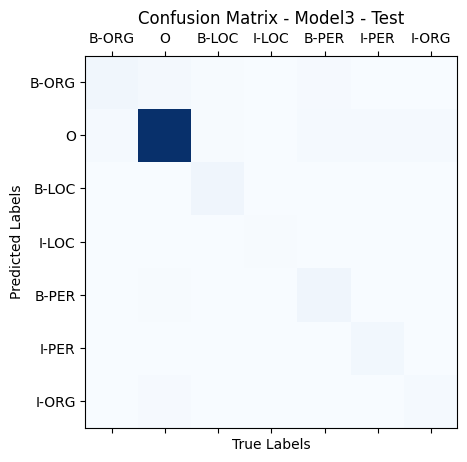

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.4839 |   0.6029 |     0.5369 |       350 |
| O       |      0.9403 |   0.9619 |     0.951  |      6567 |
| B-LOC   |      0.8129 |   0.7347 |     0.7718 |       343 |
| I-LOC   |      0.9655 |   0.5283 |     0.6829 |        53 |
| B-PER   |      0.7901 |   0.6244 |     0.6976 |       434 |
| I-PER   |      0.8673 |   0.6182 |     0.7219 |       296 |
| I-ORG   |      0.4184 |   0.41   |     0.4141 |       200 |




Model4 - Dev confusion matrix & report details


Training: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


<Figure size 1000x800 with 0 Axes>

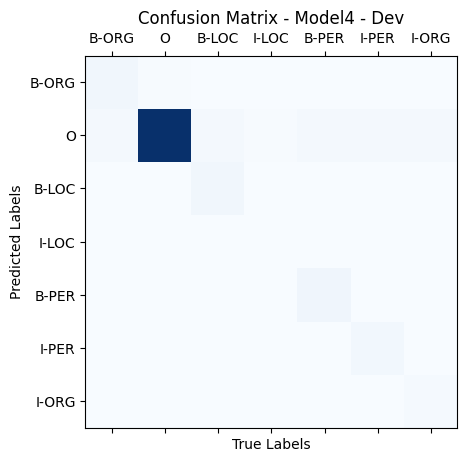

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.6779 |   0.6012 |     0.6372 |       168 |
| O       |      0.9035 |   0.9884 |     0.944  |      3096 |
| B-LOC   |      0.913  |   0.5738 |     0.7047 |       183 |
| I-LOC   |      0.9    |   0.3913 |     0.5455 |        23 |
| B-PER   |      0.9308 |   0.605  |     0.7333 |       200 |
| I-PER   |      0.9223 |   0.6051 |     0.7308 |       157 |
| I-ORG   |      0.8163 |   0.3448 |     0.4848 |       116 |




Model4 - Test confusion matrix & report details


<Figure size 1000x800 with 0 Axes>

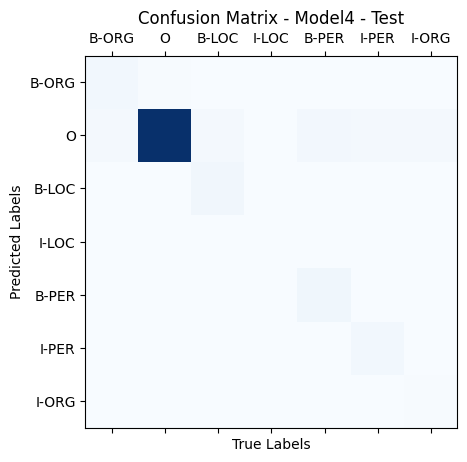

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.7003 |   0.5743 |     0.6311 |       350 |
| O       |      0.9056 |   0.9864 |     0.9443 |      6567 |
| B-LOC   |      0.9227 |   0.6268 |     0.7465 |       343 |
| I-LOC   |      0.9565 |   0.4151 |     0.5789 |        53 |
| B-PER   |      0.9194 |   0.5783 |     0.71   |       434 |
| I-PER   |      0.9082 |   0.6014 |     0.7236 |       296 |
| I-ORG   |      0.6282 |   0.245  |     0.3525 |       200 |




Model5 - Dev confusion matrix & report details


Training: 100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


<Figure size 1000x800 with 0 Axes>

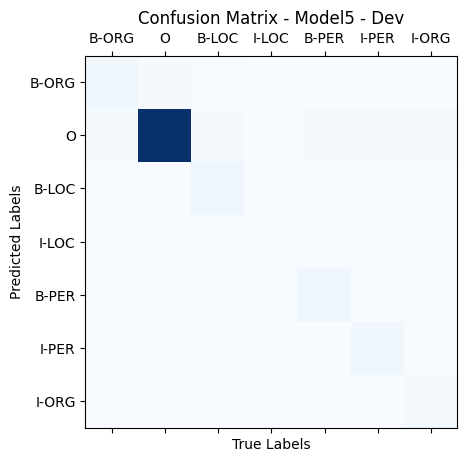

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.6564 |   0.6369 |     0.6465 |       168 |
| O       |      0.9374 |   0.9774 |     0.957  |      3096 |
| B-LOC   |      0.8493 |   0.6776 |     0.7538 |       183 |
| I-LOC   |      0.9    |   0.3913 |     0.5455 |        23 |
| B-PER   |      0.7433 |   0.695  |     0.7183 |       200 |
| I-PER   |      0.8    |   0.7134 |     0.7542 |       157 |
| I-ORG   |      0.7826 |   0.4655 |     0.5838 |       116 |




Model5 - Test confusion matrix & report details


<Figure size 1000x800 with 0 Axes>

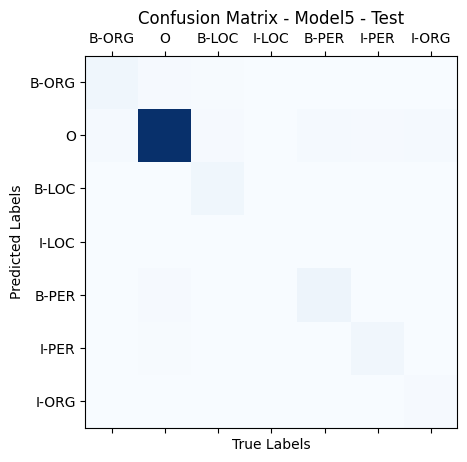

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.6398 |   0.68   |     0.6593 |       350 |
| O       |      0.9416 |   0.9752 |     0.9581 |      6567 |
| B-LOC   |      0.9038 |   0.6851 |     0.7794 |       343 |
| I-LOC   |      1      |   0.434  |     0.6053 |        53 |
| B-PER   |      0.7681 |   0.7097 |     0.7377 |       434 |
| I-PER   |      0.7805 |   0.7568 |     0.7684 |       296 |
| I-ORG   |      0.7576 |   0.375  |     0.5017 |       200 |




Model6 - Dev confusion matrix & report details


Training: 100%|██████████| 10/10 [00:35<00:00,  3.59s/it]


<Figure size 1000x800 with 0 Axes>

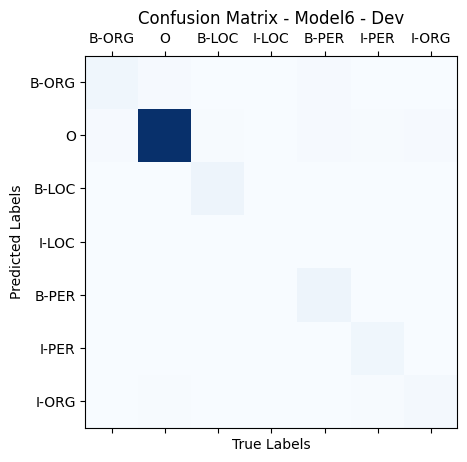

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.6409 |   0.6905 |     0.6648 |       168 |
| O       |      0.9536 |   0.9767 |     0.9651 |      3096 |
| B-LOC   |      0.8497 |   0.8033 |     0.8258 |       183 |
| I-LOC   |      0.5625 |   0.3913 |     0.4615 |        23 |
| B-PER   |      0.8931 |   0.71   |     0.7911 |       200 |
| I-PER   |      0.9055 |   0.7325 |     0.8099 |       157 |
| I-ORG   |      0.5948 |   0.5948 |     0.5948 |       116 |




Model6 - Test confusion matrix & report details


<Figure size 1000x800 with 0 Axes>

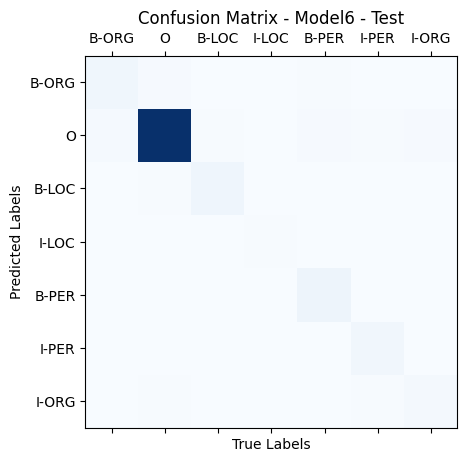

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.6136 |   0.6714 |     0.6412 |       350 |
| O       |      0.9553 |   0.97   |     0.9626 |      6567 |
| B-LOC   |      0.8065 |   0.8017 |     0.8041 |       343 |
| I-LOC   |      0.7632 |   0.5472 |     0.6374 |        53 |
| B-PER   |      0.8768 |   0.7051 |     0.7816 |       434 |
| I-PER   |      0.868  |   0.7331 |     0.7949 |       296 |
| I-ORG   |      0.5467 |   0.585  |     0.5652 |       200 |




Model7 - Dev confusion matrix & report details


Training: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


<Figure size 1000x800 with 0 Axes>

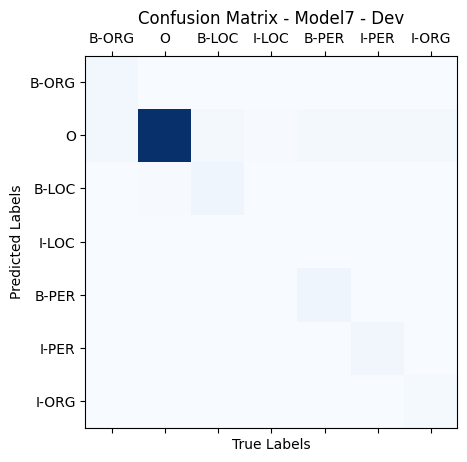

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.7941 |   0.4821 |     0.6    |       168 |
| O       |      0.9048 |   0.988  |     0.9446 |      3096 |
| B-LOC   |      0.8105 |   0.6776 |     0.7381 |       183 |
| I-LOC   |      1      |   0.3913 |     0.5625 |        23 |
| B-PER   |      0.8811 |   0.63   |     0.7347 |       200 |
| I-PER   |      0.9204 |   0.6624 |     0.7704 |       157 |
| I-ORG   |      0.8571 |   0.3103 |     0.4557 |       116 |




Model7 - Test confusion matrix & report details


<Figure size 1000x800 with 0 Axes>

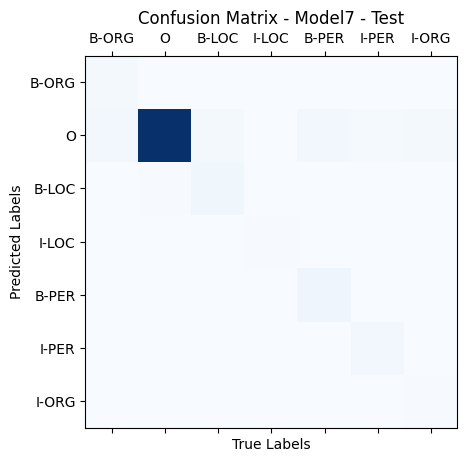

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.8922 |   0.4257 |     0.5764 |       350 |
| O       |      0.9015 |   0.9893 |     0.9434 |      6567 |
| B-LOC   |      0.8316 |   0.691  |     0.7548 |       343 |
| I-LOC   |      0.931  |   0.5094 |     0.6585 |        53 |
| B-PER   |      0.8924 |   0.5922 |     0.7119 |       434 |
| I-PER   |      0.8986 |   0.6588 |     0.7602 |       296 |
| I-ORG   |      0.86   |   0.215  |     0.344  |       200 |




Model8 - Dev confusion matrix & report details


Training: 100%|██████████| 10/10 [00:50<00:00,  5.01s/it]


<Figure size 1000x800 with 0 Axes>

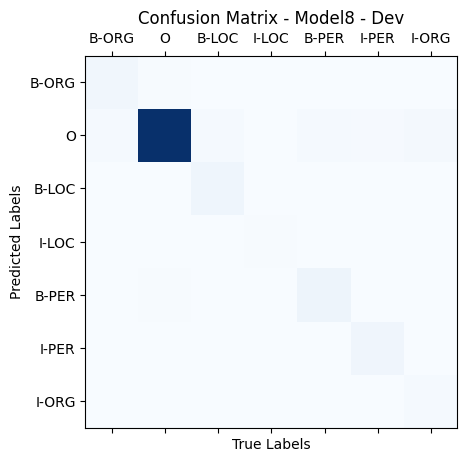

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.8077 |   0.625  |     0.7047 |       168 |
| O       |      0.9342 |   0.9819 |     0.9575 |      3096 |
| B-LOC   |      0.8882 |   0.7377 |     0.806  |       183 |
| I-LOC   |      0.75   |   0.5217 |     0.6154 |        23 |
| B-PER   |      0.7653 |   0.75   |     0.7576 |       200 |
| I-PER   |      0.8958 |   0.8217 |     0.8571 |       157 |
| I-ORG   |      0.8824 |   0.3879 |     0.5389 |       116 |




Model8 - Test confusion matrix & report details


<Figure size 1000x800 with 0 Axes>

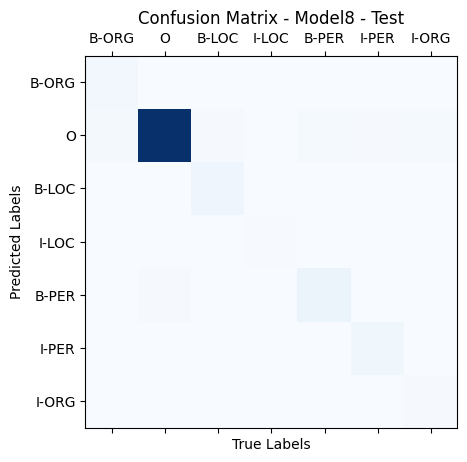

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.813  |   0.5714 |     0.6711 |       350 |
| O       |      0.9349 |   0.9801 |     0.957  |      6567 |
| B-LOC   |      0.914  |   0.7434 |     0.8199 |       343 |
| I-LOC   |      0.6452 |   0.7547 |     0.6957 |        53 |
| B-PER   |      0.7923 |   0.7558 |     0.7736 |       434 |
| I-PER   |      0.8556 |   0.8007 |     0.8272 |       296 |
| I-ORG   |      0.8395 |   0.34   |     0.484  |       200 |




Model9 - Dev confusion matrix & report details


Training: 100%|██████████| 10/10 [01:23<00:00,  8.39s/it]


<Figure size 1000x800 with 0 Axes>

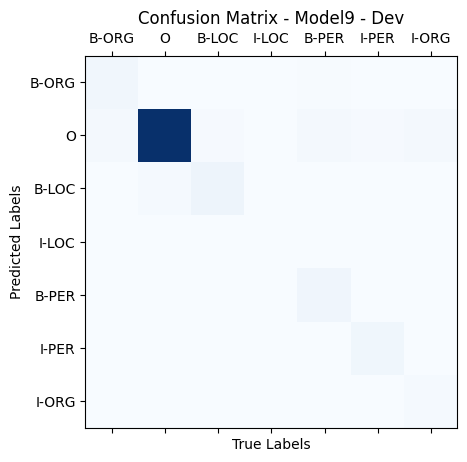

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.7612 |   0.6071 |     0.6755 |       168 |
| O       |      0.9268 |   0.9813 |     0.9532 |      3096 |
| B-LOC   |      0.7101 |   0.8033 |     0.7538 |       183 |
| I-LOC   |      0.5    |   0.4783 |     0.4889 |        23 |
| B-PER   |      0.8993 |   0.625  |     0.7375 |       200 |
| I-PER   |      0.9732 |   0.6943 |     0.8104 |       157 |
| I-ORG   |      0.8627 |   0.3793 |     0.5269 |       116 |




Model9 - Test confusion matrix & report details


<Figure size 1000x800 with 0 Axes>

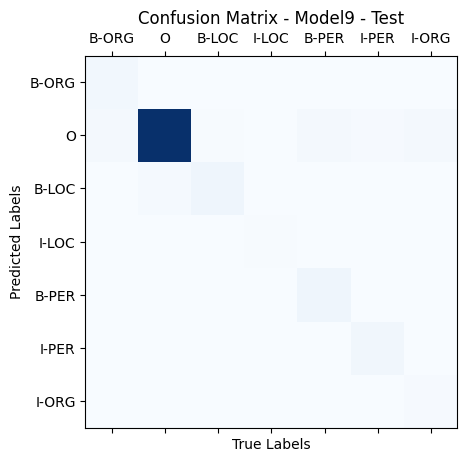

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.7559 |   0.5486 |     0.6358 |       350 |
| O       |      0.9321 |   0.9776 |     0.9543 |      6567 |
| B-LOC   |      0.6904 |   0.8192 |     0.7493 |       343 |
| I-LOC   |      0.5556 |   0.6604 |     0.6034 |        53 |
| B-PER   |      0.8946 |   0.6452 |     0.7497 |       434 |
| I-PER   |      0.9    |   0.6993 |     0.7871 |       296 |
| I-ORG   |      0.8523 |   0.375  |     0.5208 |       200 |


In [20]:
dev_results_df = pd.DataFrame(columns=columns)
test_results_df = pd.DataFrame(columns=columns)
input_size = vocab.n_words + 2    # +2 for OOV and Padding words
output_size = vocab.n_tags

for model_name, model_params in models.items():
    model_params["input_size"] = input_size
    model_params["output_size"] = output_size

    model = NERNet(
        model_params['input_size'], model_params['embedding_size'], model_params['hidden_size'],
        model_params['output_size'], model_params['n_layers'], model_params['directions']
    ).to(DEVICE)

    print('\n\n\n')
    print(f'{model_name} - Dev confusion matrix & report details')
    recall, precision, f1, recall_wo_o, precision_wo_o, f1_wo_o = train_and_evaluate_model(
        model, model_name, dl_train, dl_dev
    )

    dev_results_df = dev_results_df.append({
        'N_MODEL': model_name,
        'HIDDEN_SIZE': model_params['hidden_size'],
        'N_LAYERS': model_params['n_layers'],
        'DIRECTIONS': model_params['directions'],
        'RECALL': recall,
        'PERCISION': precision,
        'F1': f1,
        'RECALL_WO_O': recall_wo_o,
        'PERCISION_WO_O': precision_wo_o,
        'F1_WO_O': f1_wo_o
    }, ignore_index=True)

    print('\n\n\n')
    print(f'{model_name} - Test confusion matrix & report details')
    eval_tetst_report = evaluate(model, f'{model_name} - Test', dl_test)

    recall, precision, f1, recall_wo_o, precision_wo_o, f1_wo_o = extract_report_details_from_evaluation(eval_tetst_report)

    test_results_df = test_results_df.append({
        'N_MODEL': model_name,
        'HIDDEN_SIZE': model_params['hidden_size'],
        'N_LAYERS': model_params['n_layers'],
        'DIRECTIONS': model_params['directions'],
        'RECALL': recall,
        'PERCISION': precision,
        'F1': f1,
        'RECALL_WO_O': recall_wo_o,
        'PERCISION_WO_O': precision_wo_o,
        'F1_WO_O': f1_wo_o
    }, ignore_index=True)

**Dev Classification Report**

In [21]:
dev_results_df

,N_MODEL,HIDDEN_SIZE,N_LAYERS,DIRECTIONS,RECALL,PERCISION,F1,RECALL_WO_O,PERCISION_WO_O,F1_WO_O
0,Model1,500,1,1,0.884098,0.875653,0.875934,0.591499,0.712968,0.635761
1,Model2,500,2,1,0.893229,0.893117,0.886364,0.600945,0.757476,0.649287
2,Model3,500,3,1,0.894243,0.895266,0.892145,0.628099,0.735945,0.670637
3,Model4,500,1,2,0.895511,0.893841,0.884820,0.556080,0.858701,0.668475
4,Model5,500,2,2,0.905656,0.901271,0.900772,0.643447,0.769129,0.695285
5,Model6,500,3,2,0.918590,0.917667,0.916967,0.706021,0.786169,0.741191
6,Model7,800,1,2,0.897540,0.894247,0.886116,0.566706,0.855813,0.672440
7,Model8,800,2,2,0.917068,0.914006,0.911234,0.680047,0.840065,0.742193
8,Model9,800,3,2,0.906924,0.905755,0.900276,0.635183,0.828886,0.706652


**Save CSV**  
In addition, for each model use the `test` dataset and check the model metrics. 

> Metrics:
1. `RECALL`, `PERCISION`,`F1` - for all tags
2. `RECALL_WO_O`,`PERCISION_WO_O`,`F1_WO_O` - for all tags **without** the O tag.
3. *For all these metries use **weighted** ([link](https://https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support:~:text=imbalance%20into%20account.-,%27weighted%27%3A,-Calculate%20metrics%20for))*

> - Save the results in a CSV
`{student_id_1}_{student_id_n}_part6.csv`    
For example: `300123123_200456789_part_6.csv`

> - Print the results as follows:  (results here are random)

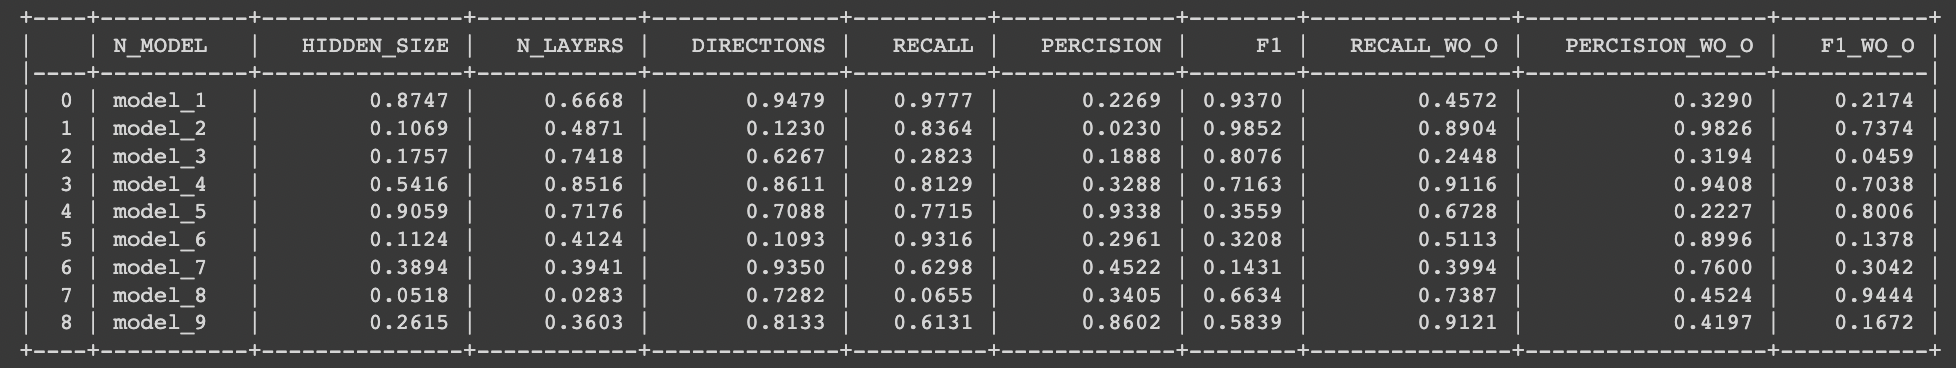

**Test Classification Report**

In [22]:
test_results_df.to_csv(f"312494925_316550797_part_6.csv")
test_results_df

,N_MODEL,HIDDEN_SIZE,N_LAYERS,DIRECTIONS,RECALL,PERCISION,F1,RECALL_WO_O,PERCISION_WO_O,F1_WO_O
0,Model1,500,1,1,0.885115,0.877551,0.877599,0.584726,0.689983,0.620361
1,Model2,500,2,1,0.898095,0.896326,0.891765,0.616945,0.730880,0.648134
2,Model3,500,3,1,0.890938,0.892598,0.889639,0.612768,0.705651,0.649219
3,Model4,500,1,2,0.897004,0.892042,0.885816,0.546539,0.838784,0.656601
4,Model5,500,2,2,0.910712,0.908224,0.906228,0.658115,0.777345,0.702947
5,Model6,500,3,2,0.915807,0.916187,0.915072,0.703461,0.762896,0.728848
6,Model7,800,1,2,0.898338,0.896782,0.884805,0.541766,0.878358,0.655328
7,Model8,800,2,2,0.917627,0.914336,0.911649,0.673031,0.833678,0.734128
8,Model9,800,3,2,0.908650,0.907040,0.902687,0.638425,0.809023,0.700487


## Task 7: 

Reset all seeds to 42.

In [23]:
SEED = 42

# Set the random seed for Python
random.seed(SEED)

# Set the random seed for numpy
np.random.seed(SEED)

# Set the random seed for torch to SEED
torch.manual_seed(SEED)


In preparation for this task you should read [this](https://discuss.pytorch.org/t/can-we-use-pre-trained-word-embeddings-for-weight-initialization-in-nn-embedding/1222) dicussion.

*TIP: make sure that vectors are aligned with the IDs in your Vocab, in other words, make sure that for example the word with ID 0 is the first vector in the GloVe matrix of vectors that you initialize nn.Embedding with.*

---


Download the GloVe embeddings from https://nlp.stanford.edu/projects/glove/ (use the 300-dim vectors from glove.6B.zip). 


In [24]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2023-06-03 11:13:20--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-06-03 11:13:20--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 38s  

2023-06-03 11:15:59 (5.19 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [25]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [26]:
embedding_size = 300
vocab_size = vocab.n_words + 2  # +2 for OOV and Padding words
glove_vectors = {}
with open('glove.6B.300d.txt', 'r', encoding='utf-8') as file:
    for line in file:
        values = line.strip().split()
        word = values[0]
        vector = [float(val) for val in values[1:]]
        glove_vectors[word] = vector

embedding_weights = torch.zeros((vocab_size, embedding_size))
for word, idx in vocab.word2id.items():
    if word in glove_vectors:
        embedding_weights[idx] = torch.tensor(glove_vectors[word])
    else:
        embedding_weights[idx] = torch.randn(embedding_size)

Then intialize the `nn.Embedding` module in your `NERNet` with these embeddings, so that you can start your training with pre-trained vectors. 

In [27]:
def intialize_model_pretrain(model_params, embedding_weights):
  model = NERNet(
    model_params['input_size'], model_params['embedding_size'], model_params['hidden_size'],
    model_params['output_size'], model_params['n_layers'], model_params['directions']
    ).to(DEVICE)
  model.embedding.weight.data.copy_(embedding_weights)

  return model

Repeat `Task 6`

Same as `Task 6`, please display:

1. Print a `classification_report` in a tabulate format.
2. Display a `confusion matrix` plot: where the predicted labels are the rows, and the true labels are the columns.

Make sure to use the title for the plot, axis names, and the names of the tags on the X-axis.





Model1 - Dev confusion matrix & report details


Training: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


<Figure size 1000x800 with 0 Axes>

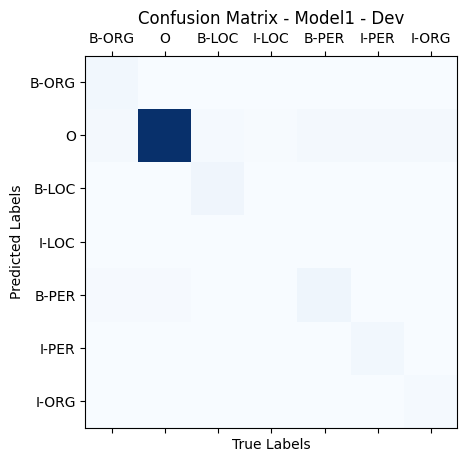

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.7928 |   0.5238 |     0.6308 |       168 |
| O       |      0.9119 |   0.9861 |     0.9475 |      3096 |
| B-LOC   |      0.8897 |   0.6612 |     0.7586 |       183 |
| I-LOC   |      1      |   0.4348 |     0.6061 |        23 |
| B-PER   |      0.6818 |   0.675  |     0.6784 |       200 |
| I-PER   |      0.9255 |   0.5541 |     0.6932 |       157 |
| I-ORG   |      0.8696 |   0.3448 |     0.4938 |       116 |




Model1 - Test confusion matrix & report details


<Figure size 1000x800 with 0 Axes>

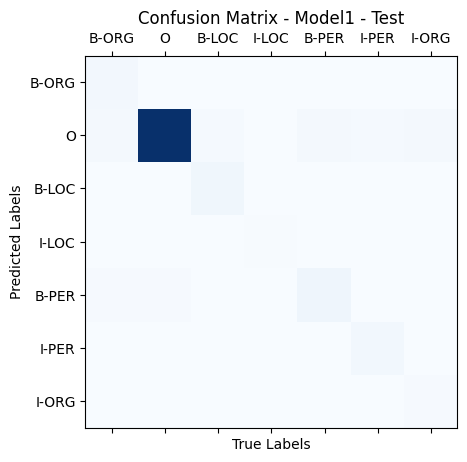

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.7668 |   0.4886 |     0.5969 |       350 |
| O       |      0.9222 |   0.9839 |     0.952  |      6567 |
| B-LOC   |      0.9352 |   0.6735 |     0.7831 |       343 |
| I-LOC   |      0.9032 |   0.5283 |     0.6667 |        53 |
| B-PER   |      0.6652 |   0.682  |     0.6735 |       434 |
| I-PER   |      0.9024 |   0.625  |     0.7385 |       296 |
| I-ORG   |      0.7558 |   0.325  |     0.4545 |       200 |




Model2 - Dev confusion matrix & report details


Training: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


<Figure size 1000x800 with 0 Axes>

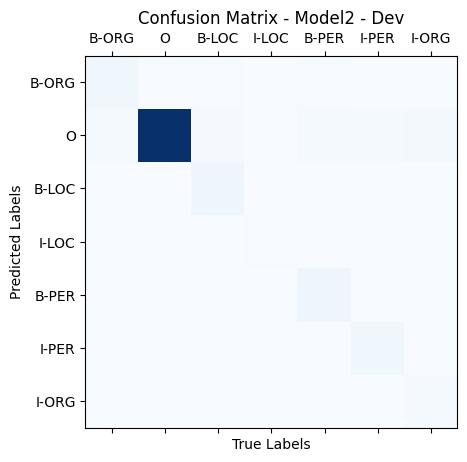

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.6886 |   0.6845 |     0.6866 |       168 |
| O       |      0.9311 |   0.9858 |     0.9576 |      3096 |
| B-LOC   |      0.9038 |   0.7705 |     0.8319 |       183 |
| I-LOC   |      1      |   0.6087 |     0.7568 |        23 |
| B-PER   |      0.8438 |   0.675  |     0.75   |       200 |
| I-PER   |      0.9483 |   0.7006 |     0.8059 |       157 |
| I-ORG   |      0.8462 |   0.3793 |     0.5238 |       116 |




Model2 - Test confusion matrix & report details


<Figure size 1000x800 with 0 Axes>

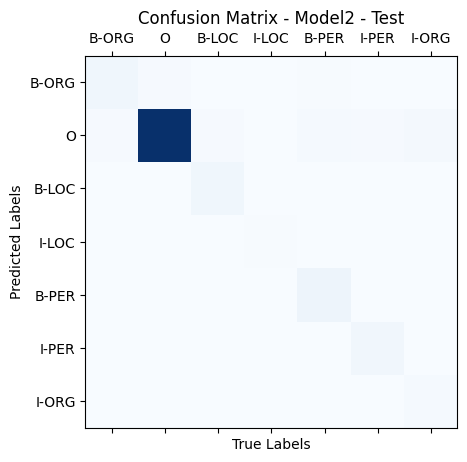

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.6757 |   0.7086 |     0.6918 |       350 |
| O       |      0.9411 |   0.9854 |     0.9627 |      6567 |
| B-LOC   |      0.9048 |   0.7201 |     0.8019 |       343 |
| I-LOC   |      0.9231 |   0.6792 |     0.7826 |        53 |
| B-PER   |      0.8694 |   0.7212 |     0.7884 |       434 |
| I-PER   |      0.903  |   0.723  |     0.803  |       296 |
| I-ORG   |      0.8352 |   0.38   |     0.5223 |       200 |




Model3 - Dev confusion matrix & report details


Training: 100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


<Figure size 1000x800 with 0 Axes>

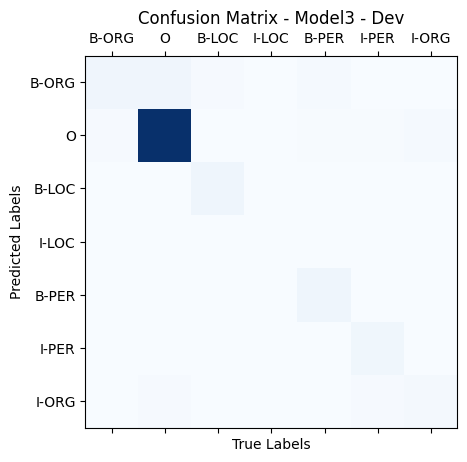

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.3636 |   0.6905 |     0.4764 |       168 |
| O       |      0.9626 |   0.948  |     0.9552 |      3096 |
| B-LOC   |      0.8671 |   0.7486 |     0.8035 |       183 |
| I-LOC   |      0.7692 |   0.4348 |     0.5556 |        23 |
| B-PER   |      0.8867 |   0.665  |     0.76   |       200 |
| I-PER   |      0.9643 |   0.6879 |     0.803  |       157 |
| I-ORG   |      0.4366 |   0.5345 |     0.4806 |       116 |




Model3 - Test confusion matrix & report details


<Figure size 1000x800 with 0 Axes>

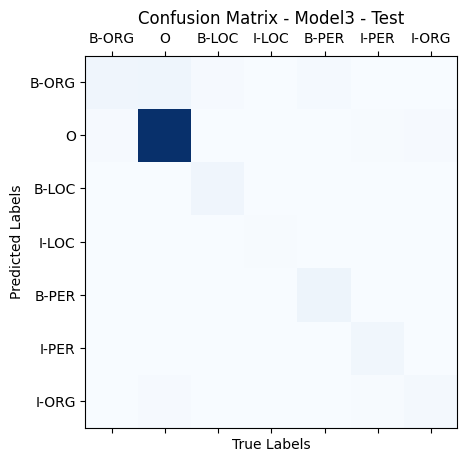

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.359  |   0.7057 |     0.4759 |       350 |
| O       |      0.9674 |   0.9411 |     0.9541 |      6567 |
| B-LOC   |      0.8683 |   0.7114 |     0.7821 |       343 |
| I-LOC   |      0.871  |   0.5094 |     0.6429 |        53 |
| B-PER   |      0.8448 |   0.6774 |     0.7519 |       434 |
| I-PER   |      0.9009 |   0.7061 |     0.7917 |       296 |
| I-ORG   |      0.3964 |   0.545  |     0.4589 |       200 |




Model4 - Dev confusion matrix & report details


Training: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


<Figure size 1000x800 with 0 Axes>

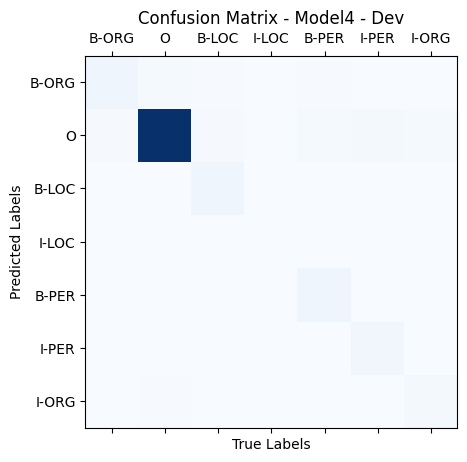

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.5794 |   0.7381 |     0.6492 |       168 |
| O       |      0.9363 |   0.9774 |     0.9564 |      3096 |
| B-LOC   |      0.9252 |   0.7432 |     0.8242 |       183 |
| I-LOC   |      1      |   0.3913 |     0.5625 |        23 |
| B-PER   |      0.8552 |   0.62   |     0.7188 |       200 |
| I-PER   |      0.9    |   0.6306 |     0.7416 |       157 |
| I-ORG   |      0.686  |   0.5086 |     0.5842 |       116 |




Model4 - Test confusion matrix & report details


<Figure size 1000x800 with 0 Axes>

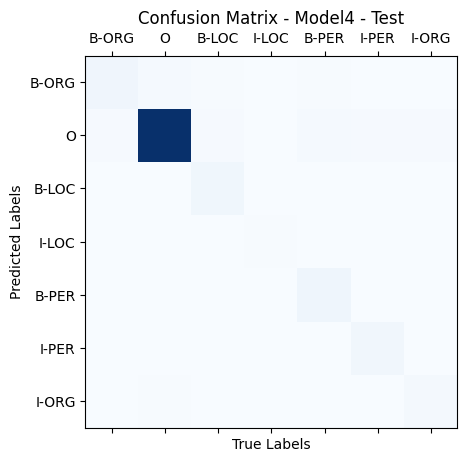

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.5837 |   0.7371 |     0.6515 |       350 |
| O       |      0.9433 |   0.9759 |     0.9594 |      6567 |
| B-LOC   |      0.9283 |   0.7172 |     0.8092 |       343 |
| I-LOC   |      0.9667 |   0.5472 |     0.6988 |        53 |
| B-PER   |      0.9023 |   0.6382 |     0.7476 |       434 |
| I-PER   |      0.8957 |   0.6959 |     0.7833 |       296 |
| I-ORG   |      0.5829 |   0.51   |     0.544  |       200 |




Model5 - Dev confusion matrix & report details


Training: 100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


<Figure size 1000x800 with 0 Axes>

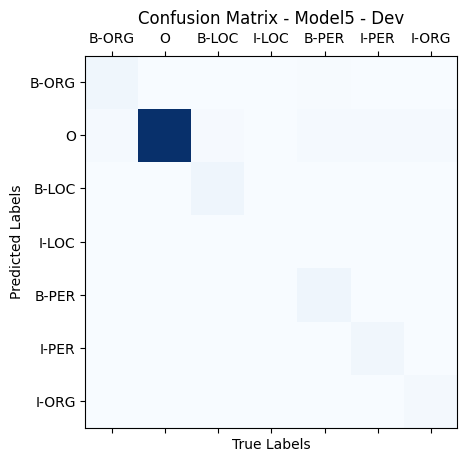

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.7613 |   0.7024 |     0.7307 |       168 |
| O       |      0.9362 |   0.9945 |     0.9644 |      3096 |
| B-LOC   |      0.958  |   0.7486 |     0.8405 |       183 |
| I-LOC   |      0.9    |   0.3913 |     0.5455 |        23 |
| B-PER   |      0.8645 |   0.67   |     0.7549 |       200 |
| I-PER   |      0.9245 |   0.6242 |     0.7452 |       157 |
| I-ORG   |      0.7294 |   0.5345 |     0.6169 |       116 |




Model5 - Test confusion matrix & report details


<Figure size 1000x800 with 0 Axes>

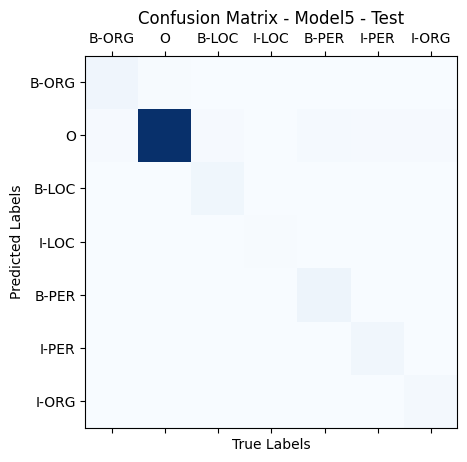

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.7683 |   0.7486 |     0.7583 |       350 |
| O       |      0.9461 |   0.9895 |     0.9673 |      6567 |
| B-LOC   |      0.9614 |   0.7259 |     0.8272 |       343 |
| I-LOC   |      0.9706 |   0.6226 |     0.7586 |        53 |
| B-PER   |      0.898  |   0.7304 |     0.8056 |       434 |
| I-PER   |      0.9286 |   0.7027 |     0.8    |       296 |
| I-ORG   |      0.6646 |   0.545  |     0.5989 |       200 |




Model6 - Dev confusion matrix & report details


Training: 100%|██████████| 10/10 [00:35<00:00,  3.59s/it]


<Figure size 1000x800 with 0 Axes>

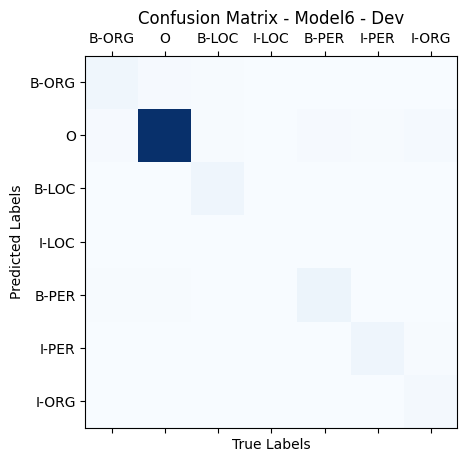

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.7    |   0.6667 |     0.6829 |       168 |
| O       |      0.956  |   0.9816 |     0.9686 |      3096 |
| B-LOC   |      0.9216 |   0.7705 |     0.8393 |       183 |
| I-LOC   |      0.7692 |   0.4348 |     0.5556 |        23 |
| B-PER   |      0.8061 |   0.79   |     0.798  |       200 |
| I-PER   |      0.7941 |   0.8599 |     0.8257 |       157 |
| I-ORG   |      0.75   |   0.4655 |     0.5745 |       116 |




Model6 - Test confusion matrix & report details


<Figure size 1000x800 with 0 Axes>

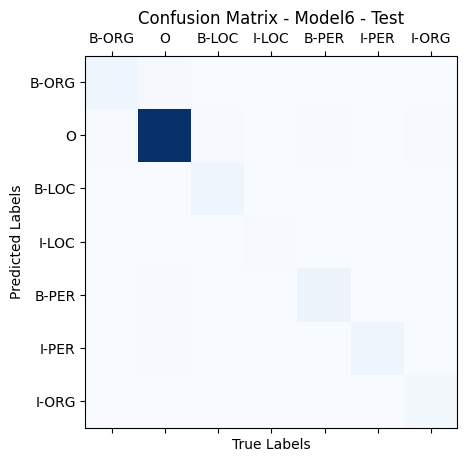

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.7112 |   0.7457 |     0.728  |       350 |
| O       |      0.9675 |   0.9747 |     0.9711 |      6567 |
| B-LOC   |      0.9458 |   0.7638 |     0.8452 |       343 |
| I-LOC   |      0.9697 |   0.6038 |     0.7442 |        53 |
| B-PER   |      0.8246 |   0.8341 |     0.8293 |       434 |
| I-PER   |      0.7917 |   0.8986 |     0.8418 |       296 |
| I-ORG   |      0.7257 |   0.635  |     0.6773 |       200 |




Model7 - Dev confusion matrix & report details


Training: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


<Figure size 1000x800 with 0 Axes>

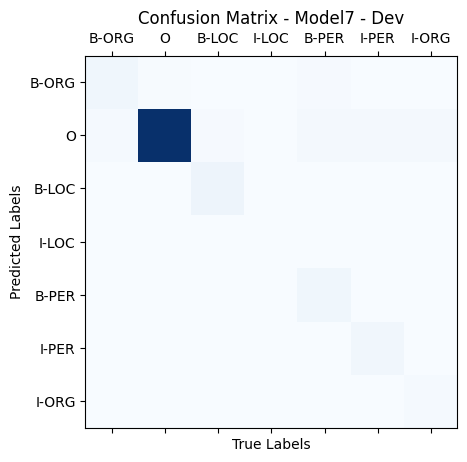

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.6517 |   0.6905 |     0.6705 |       168 |
| O       |      0.9293 |   0.9851 |     0.9564 |      3096 |
| B-LOC   |      0.8571 |   0.7869 |     0.8205 |       183 |
| I-LOC   |      0.8333 |   0.4348 |     0.5714 |        23 |
| B-PER   |      0.8797 |   0.585  |     0.7027 |       200 |
| I-PER   |      0.8509 |   0.6178 |     0.7159 |       157 |
| I-ORG   |      0.8036 |   0.3879 |     0.5233 |       116 |




Model7 - Test confusion matrix & report details


<Figure size 1000x800 with 0 Axes>

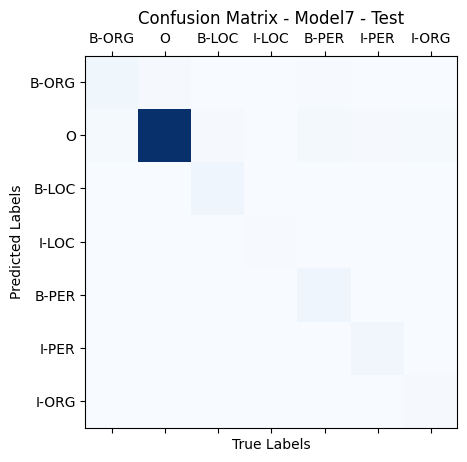

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.6322 |   0.6629 |     0.6471 |       350 |
| O       |      0.9352 |   0.9846 |     0.9593 |      6567 |
| B-LOC   |      0.8684 |   0.7697 |     0.8161 |       343 |
| I-LOC   |      0.8919 |   0.6226 |     0.7333 |        53 |
| B-PER   |      0.9187 |   0.5991 |     0.7252 |       434 |
| I-PER   |      0.8843 |   0.723  |     0.7955 |       296 |
| I-ORG   |      0.7708 |   0.37   |     0.5    |       200 |




Model8 - Dev confusion matrix & report details


Training: 100%|██████████| 10/10 [00:49<00:00,  4.99s/it]


<Figure size 1000x800 with 0 Axes>

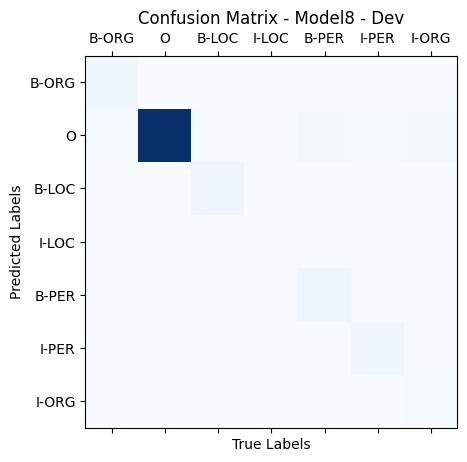

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.7548 |   0.6964 |     0.7245 |       168 |
| O       |      0.9333 |   0.9942 |     0.9628 |      3096 |
| B-LOC   |      0.929  |   0.7869 |     0.8521 |       183 |
| I-LOC   |      0.6667 |   0.4348 |     0.5263 |        23 |
| B-PER   |      0.875  |   0.665  |     0.7557 |       200 |
| I-PER   |      0.879  |   0.6943 |     0.7758 |       157 |
| I-ORG   |      0.9091 |   0.3448 |     0.5    |       116 |




Model8 - Test confusion matrix & report details


<Figure size 1000x800 with 0 Axes>

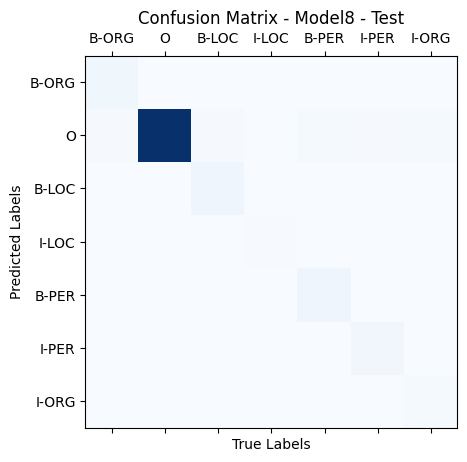

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.791  |   0.7029 |     0.7443 |       350 |
| O       |      0.9432 |   0.9931 |     0.9675 |      6567 |
| B-LOC   |      0.8885 |   0.7901 |     0.8364 |       343 |
| I-LOC   |      0.9412 |   0.6038 |     0.7356 |        53 |
| B-PER   |      0.9077 |   0.7028 |     0.7922 |       434 |
| I-PER   |      0.8828 |   0.7635 |     0.8188 |       296 |
| I-ORG   |      0.9186 |   0.395  |     0.5524 |       200 |




Model9 - Dev confusion matrix & report details


Training: 100%|██████████| 10/10 [01:23<00:00,  8.36s/it]


<Figure size 1000x800 with 0 Axes>

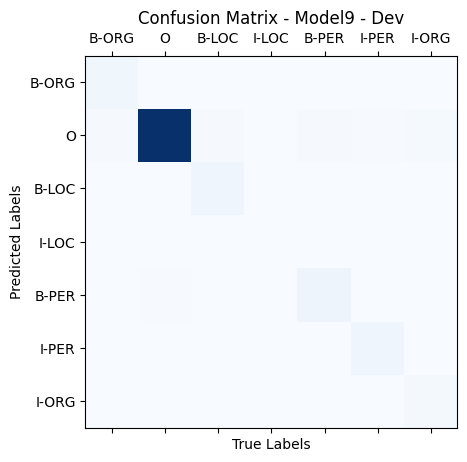

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.8056 |   0.6905 |     0.7436 |       168 |
| O       |      0.9501 |   0.9893 |     0.9693 |      3096 |
| B-LOC   |      0.9262 |   0.7541 |     0.8313 |       183 |
| I-LOC   |      0.8333 |   0.4348 |     0.5714 |        23 |
| B-PER   |      0.8212 |   0.735  |     0.7757 |       200 |
| I-PER   |      0.7901 |   0.8153 |     0.8025 |       157 |
| I-ORG   |      0.8219 |   0.5172 |     0.6349 |       116 |




Model9 - Test confusion matrix & report details


<Figure size 1000x800 with 0 Axes>

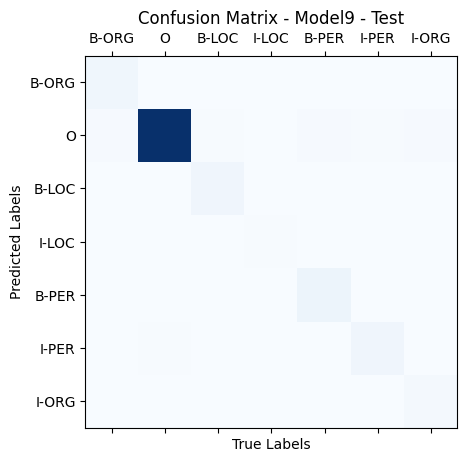

| Label   |   Precision |   Recall |   F1-score |   Support |
|---------|-------------|----------|------------|-----------|
| B-ORG   |      0.817  |   0.7143 |     0.7622 |       350 |
| O       |      0.9619 |   0.9868 |     0.9741 |      6567 |
| B-LOC   |      0.917  |   0.7726 |     0.8386 |       343 |
| I-LOC   |      0.9167 |   0.6226 |     0.7416 |        53 |
| B-PER   |      0.8841 |   0.8088 |     0.8448 |       434 |
| I-PER   |      0.8137 |   0.8851 |     0.8479 |       296 |
| I-ORG   |      0.75   |   0.585  |     0.6573 |       200 |


In [28]:
dev_results_df = pd.DataFrame(columns=columns)
test_results_df = pd.DataFrame(columns=columns)
input_size = vocab.n_words + 2    # +2 for OOV and Padding words
output_size = vocab.n_tags

for model_name, model_params in models.items():
    model_params["input_size"] = input_size
    model_params["output_size"] = output_size

    model = intialize_model_pretrain(model_params, embedding_weights)

    print('\n\n\n')
    print(f'{model_name} - Dev confusion matrix & report details')
    recall, precision, f1, recall_wo_o, precision_wo_o, f1_wo_o = train_and_evaluate_model(
        model, model_name, dl_train, dl_dev
    )

    dev_results_df = dev_results_df.append({
        'N_MODEL': model_name,
        'HIDDEN_SIZE': model_params['hidden_size'],
        'N_LAYERS': model_params['n_layers'],
        'DIRECTIONS': model_params['directions'],
        'RECALL': recall,
        'PERCISION': precision,
        'F1': f1,
        'RECALL_WO_O': recall_wo_o,
        'PERCISION_WO_O': precision_wo_o,
        'F1_WO_O': f1_wo_o
    }, ignore_index=True)

    print('\n\n\n')
    print(f'{model_name} - Test confusion matrix & report details')
    eval_tetst_report = evaluate(model, f'{model_name} - Test', dl_test)

    recall, precision, f1, recall_wo_o, precision_wo_o, f1_wo_o = extract_report_details_from_evaluation(eval_tetst_report)

    test_results_df = test_results_df.append({
        'N_MODEL': model_name,
        'HIDDEN_SIZE': model_params['hidden_size'],
        'N_LAYERS': model_params['n_layers'],
        'DIRECTIONS': model_params['directions'],
        'RECALL': recall,
        'PERCISION': precision,
        'F1': f1,
        'RECALL_WO_O': recall_wo_o,
        'PERCISION_WO_O': precision_wo_o,
        'F1_WO_O': f1_wo_o
    }, ignore_index=True)

- Save the results in a CSV {student_id_1}_{student_id_n}_part7.csv  
For example: 300123123_200456789_part_7.csv

- Print the results as follows:

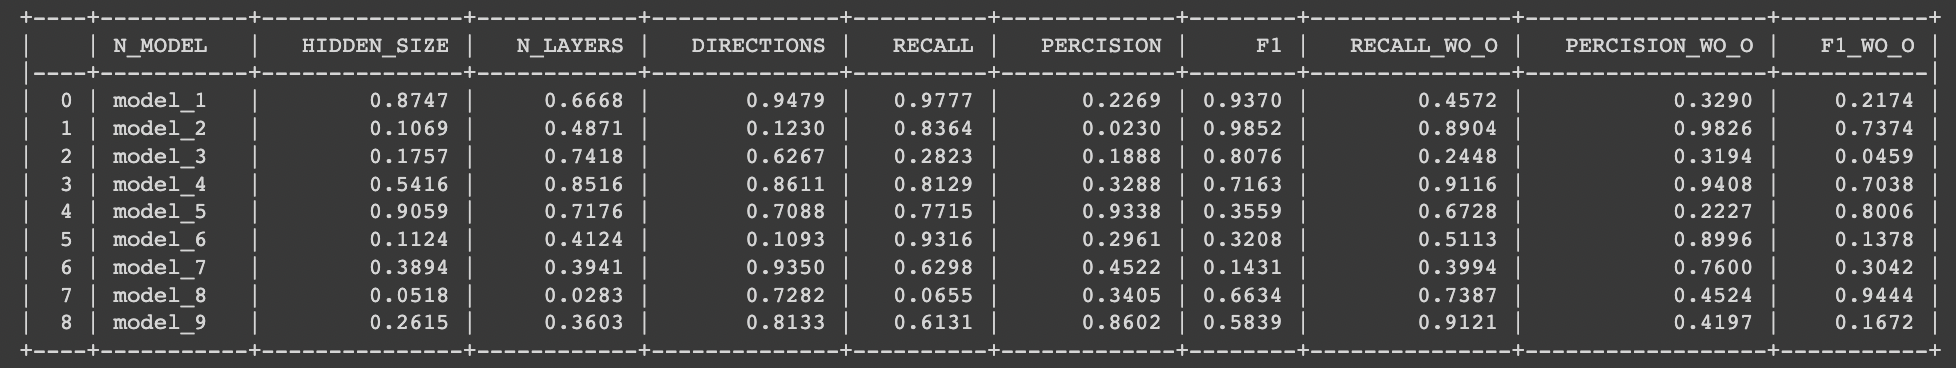

**Dev Classification Report**

In [29]:
dev_results_df

,N_MODEL,HIDDEN_SIZE,N_LAYERS,DIRECTIONS,RECALL,PERCISION,F1,RECALL_WO_O,PERCISION_WO_O,F1_WO_O
0,Model1,500,1,1,0.896272,0.893926,0.886166,0.567887,0.828273,0.661800
1,Model2,500,2,1,0.915800,0.913625,0.909743,0.659976,0.849912,0.734664
2,Model3,500,3,1,0.887903,0.912269,0.895542,0.668241,0.728258,0.677300
3,Model4,500,1,2,0.907177,0.907998,0.903314,0.650531,0.804685,0.709326
4,Model5,500,2,2,0.922394,0.919327,0.916710,0.658796,0.857833,0.742215
5,Model6,500,3,2,0.925437,0.922266,0.922082,0.720189,0.799103,0.752026
6,Model7,800,1,2,0.907685,0.904235,0.900489,0.624557,0.812572,0.696073
7,Model8,800,2,2,0.920872,0.918107,0.913376,0.652893,0.862599,0.732798
8,Model9,800,3,2,0.928734,0.925442,0.924665,0.707202,0.835452,0.761497


**Test Classification Report**

In [30]:
test_results_df.to_csv(f"312494925_316550797_part_7.csv")
test_results_df

,N_MODEL,HIDDEN_SIZE,N_LAYERS,DIRECTIONS,RECALL,PERCISION,F1,RECALL_WO_O,PERCISION_WO_O,F1_WO_O
0,Model1,500,1,1,0.902220,0.897750,0.893686,0.582339,0.801913,0.665052
1,Model2,500,2,1,0.922601,0.920492,0.917779,0.676611,0.839746,0.741643
2,Model3,500,3,1,0.886813,0.914158,0.896122,0.674224,0.705391,0.669058
3,Model4,500,1,2,0.913138,0.914968,0.910817,0.667064,0.803827,0.720614
4,Model5,500,2,2,0.931214,0.929377,0.927816,0.702864,0.863745,0.773013
5,Model6,500,3,2,0.935460,0.936028,0.934843,0.781623,0.812699,0.792782
6,Model7,800,1,2,0.915079,0.912595,0.909266,0.642601,0.824009,0.713314
7,Model8,800,2,2,0.931821,0.929791,0.926451,0.691527,0.877379,0.765560
8,Model9,800,3,2,0.941162,0.938989,0.938976,0.762530,0.849406,0.801182


<br><br><br><br><br><br>
**Good luck!**